# Notebook 01-calculate_censo_nan_values_v1 (Function developing)

This notebook contains ALL steps explored in order to create a function that calculates/assigns values to nan values present in pop data of censo block gdf.

The resulting function (__aup > analysis > calculate_censo_nan_values_v1__) takes an area of interest as an input and:
1. Checks for differences in AGEBs (Drops any AGEB that's not present in both (block and ageb) gdfs).
2. Calculates NaN values AGEB by AGEB. (First using equations within the block gdf, then filling all remaining NaNs using AGEB data)
3. Returns a block_gdf where most of pop data has no NaNs.

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/jovyan/accesibilidad-urbana/aup/data.py:25: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


# Part 1: Developing code for one AGEB only

## Load area of experiment (AGEB and blocks)

In [2]:
chosen_ageb = '0515'

#### Load AGEB

In [3]:
pop_schema = 'censoageb'
pop_table = 'censoageb_2020'
ent = '01'

query = f"SELECT * FROM {pop_schema}.{pop_table} WHERE \"cve_ent\" LIKE \'{ent}\'"
ags_pop_ageb = aup.gdf_from_query(query, geometry_col='geometry')
ags_pop_ageb = ags_pop_ageb.set_crs("EPSG:4326")

chosen_ageb_gdf = ags_pop_ageb.loc[ags_pop_ageb.cve_ageb == chosen_ageb]

# Show
print(f"Chosen AGEB has a population of {chosen_ageb_gdf.pobtot.unique()}.")
chosen_ageb_gdf

AGEB elegido con población de [2585].


,cve_geo,cve_ent,cve_mun,cve_loc,cve_ageb,geometry,entidad,nom_ent,mun,nom_mun,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic,cve_geo_ageb
239,0100100010515,01,001,0001,0515,"POLYGON ((-102.29278 21.89010, -102.29275 21.8...",1,Aguascalientes,1,Aguascalientes,...,759.0,621.0,454.0,325.0,124.0,19.0,24.0,204.0,NaN,0100100010515


#### Load blocks

In [ ]:
pop_schema = 'censo_mza'
pop_table = 'censo_mza_2020'
ent = '01'

query = f"SELECT * FROM {pop_schema}.{pop_table} WHERE \"CVE_ENT\" LIKE \'{ent}\'"
ags_pop_mza = aup.gdf_from_query(query, geometry_col='geometry')
ags_pop_mza = ags_pop_mza.set_crs("EPSG:4326")

mza_gdf = ags_pop_mza.loc[ags_pop_mza.CVE_AGEB == chosen_ageb]

# Show
print(mza_gdf.shape)
mza_gdf.head(1)

<Axes: >

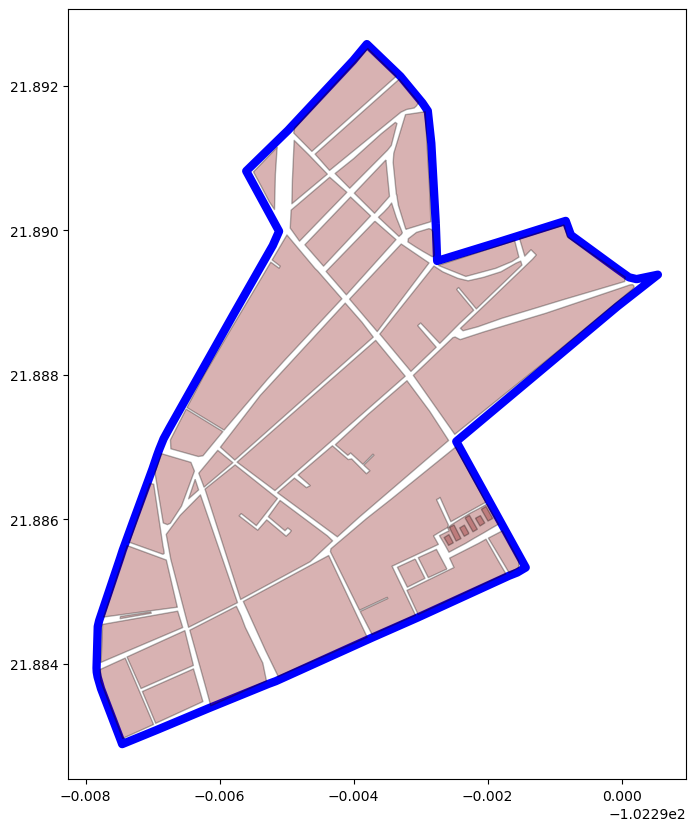

In [5]:
# Show
fig, ax = plt.subplots(figsize=(10, 10))
mza_gdf.plot(ax=ax, color="maroon", alpha=0.3, edgecolor="black",zorder=1)
chosen_ageb_gdf.boundary.plot(ax=ax, edgecolor="blue", linewidth=6,zorder=0)

## First methodology develop

### Filter data for columns of interest

In [20]:
columns_of_interest = ['POBTOT','POBFEM','POBMAS',
                       'P_0A2','P_0A2_F','P_0A2_M',
                       'P_3A5','P_3A5_F','P_3A5_M',
                       'P_6A11','P_6A11_F','P_6A11_M',
                       'P_12A14','P_12A14_F','P_12A14_M',
                       'P_15A17','P_15A17_F','P_15A17_M',
                       'P_18A24','P_18A24_F','P_18A24_M',
                       'P_60YMAS','P_60YMAS_F','P_60YMAS_M',
                       'P_3YMAS','P_3YMAS_F','P_3YMAS_M',
                       'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
                       'P_15YMAS','P_15YMAS_F','P_15YMAS_M',
                       'P_18YMAS','P_18YMAS_F','P_18YMAS_M',
                       'REL_H_M','POB0_14','POB15_64','POB65_MAS']

# Filter for blocks
mza_gdf_f = mza_gdf[columns_of_interest+['CVEGEO','geometry']]

# Filter for ageb
ageb_columns_of_interest = [x.lower() for x in columns_of_interest]
chosen_ageb_gdf_f = chosen_ageb_gdf[ageb_columns_of_interest+['geometry']]

### Equations testing

#### Check if [P_0A2 = POBTOT - P_3YMAS] -----> SUCCESS

In [60]:
test_gdf = mza_gdf_f.copy()

test_gdf['P_3YMAS'] = pd.to_numeric(test_gdf['P_3YMAS'])
test_gdf['P_0A2'] = pd.to_numeric(test_gdf['P_0A2'])

test_gdf['test'] = test_gdf['POBTOT'] - test_gdf['P_3YMAS']

test_gdf = test_gdf[['POBTOT','P_3YMAS','test','P_0A2']]

test_gdf['diff'] = test_gdf['P_0A2'] - test_gdf['test']

print(f' Difference: {test_gdf["diff"].sum()}')
test_gdf

 Difference: 0.0


,POBTOT,P_3YMAS,test,P_0A2,diff
2034,179,173.0,6.0,6.0,0.0
2035,176,172.0,4.0,4.0,0.0
2036,81,77.0,4.0,4.0,0.0
2037,145,144.0,1.0,NaN,NaN
2038,97,96.0,1.0,NaN,NaN
2039,180,176.0,4.0,4.0,0.0
2040,88,85.0,3.0,3.0,0.0
2041,15,14.0,1.0,NaN,NaN
2042,139,131.0,8.0,8.0,0.0
2043,65,62.0,3.0,3.0,0.0


#### Check if [POBTOT - P_12YMAS = (P_0A2 + P_3A5 + P_6A11)] -----> SUCCESS

In [31]:
test_gdf = mza_gdf_f.copy()

test_gdf['P_12YMAS'] = pd.to_numeric(test_gdf['P_12YMAS'])
test_gdf['P_0A2'] = pd.to_numeric(test_gdf['P_0A2'])
test_gdf['P_3A5'] = pd.to_numeric(test_gdf['P_3A5'])
test_gdf['P_6A11'] = pd.to_numeric(test_gdf['P_6A11'])

test_gdf['side_1'] = test_gdf['POBTOT'] - test_gdf['P_12YMAS'] 
test_gdf['side_2'] = test_gdf['P_0A2'] + test_gdf['P_3A5'] + test_gdf['P_6A11']

test_gdf = test_gdf[['POBTOT','P_12YMAS','P_0A2','P_3A5','P_6A11','side_1','side_2']]

test_gdf['diff'] = test_gdf['side_1'] - test_gdf['side_2']

print(f' Difference: {test_gdf["diff"].sum()}')
test_gdf

 Difference: 0.0


,POBTOT,P_12YMAS,P_0A2,P_3A5,P_6A11,side_1,side_2,diff
2029,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2030,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2031,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2032,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2033,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2054,179,155.0,6.0,9.0,9.0,24.0,24.0,0.0
2055,176,162.0,4.0,NaN,8.0,14.0,NaN,NaN
2056,81,72.0,4.0,3.0,NaN,9.0,NaN,NaN
2057,145,135.0,NaN,NaN,7.0,10.0,NaN,NaN
2058,97,93.0,NaN,NaN,NaN,4.0,NaN,NaN


#### Check if [POBTOT - P_15YMAS = (P_0A2 + P_3A5 + P_6A11 + P_12A14)] -----> SUCCESS

In [32]:
test_gdf = mza_gdf_f.copy()

test_gdf['P_15YMAS'] = pd.to_numeric(test_gdf['P_15YMAS'])
test_gdf['P_0A2'] = pd.to_numeric(test_gdf['P_0A2'])
test_gdf['P_3A5'] = pd.to_numeric(test_gdf['P_3A5'])
test_gdf['P_6A11'] = pd.to_numeric(test_gdf['P_6A11'])
test_gdf['P_12A14'] = pd.to_numeric(test_gdf['P_12A14'])

test_gdf['side_1'] = test_gdf['POBTOT'] - test_gdf['P_15YMAS'] 
test_gdf['side_2'] = test_gdf['P_0A2'] + test_gdf['P_3A5'] + test_gdf['P_6A11'] + test_gdf['P_12A14']

test_gdf = test_gdf[['POBTOT','P_12YMAS','P_0A2','P_3A5','P_6A11','P_12A14','side_1','side_2']]

test_gdf['diff'] = test_gdf['side_1'] - test_gdf['side_2']

print(f' Difference: {test_gdf["diff"].sum()}')
test_gdf

 Difference: 0.0


,POBTOT,P_12YMAS,P_0A2,P_3A5,P_6A11,P_12A14,side_1,side_2,diff
2029,1,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2030,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2031,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2032,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2033,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2054,179,155,6.0,9.0,9.0,7.0,31.0,31.0,0.0
2055,176,162,4.0,NaN,8.0,5.0,19.0,NaN,NaN
2056,81,72,4.0,3.0,NaN,NaN,10.0,NaN,NaN
2057,145,135,NaN,NaN,7.0,3.0,13.0,NaN,NaN
2058,97,93,NaN,NaN,NaN,4.0,8.0,NaN,NaN


#### Check if [POBTOT - P_18YMAS = (P_0A2 + P_3A5 + P_6A11 + P_12A14 + P_15A17)] -----> SUCCESS

In [33]:
test_gdf = mza_gdf_f.copy()

test_gdf['P_18YMAS'] = pd.to_numeric(test_gdf['P_18YMAS'])
test_gdf['P_0A2'] = pd.to_numeric(test_gdf['P_0A2'])
test_gdf['P_3A5'] = pd.to_numeric(test_gdf['P_3A5'])
test_gdf['P_6A11'] = pd.to_numeric(test_gdf['P_6A11'])
test_gdf['P_12A14'] = pd.to_numeric(test_gdf['P_12A14'])
test_gdf['P_15A17'] = pd.to_numeric(test_gdf['P_15A17'])

test_gdf['side_1'] = test_gdf['POBTOT'] - test_gdf['P_18YMAS'] 
test_gdf['side_2'] = test_gdf['P_0A2'] + test_gdf['P_3A5'] + test_gdf['P_6A11'] + test_gdf['P_12A14'] + test_gdf['P_15A17']

test_gdf = test_gdf[['POBTOT','P_18YMAS','P_0A2','P_3A5','P_6A11','P_12A14','P_15A17','side_1','side_2']]

test_gdf['diff'] = test_gdf['side_1'] - test_gdf['side_2']

print(f' Difference: {test_gdf["diff"].sum()}')
test_gdf

 Difference: 0.0


,POBTOT,P_18YMAS,P_0A2,P_3A5,P_6A11,P_12A14,P_15A17,side_1,side_2,diff
2029,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2030,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2031,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2032,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2033,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2054,179,142.0,6.0,9.0,9.0,7.0,6.0,37.0,37.0,0.0
2055,176,153.0,4.0,NaN,8.0,5.0,4.0,23.0,NaN,NaN
2056,81,69.0,4.0,3.0,NaN,NaN,NaN,12.0,NaN,NaN
2057,145,130.0,NaN,NaN,7.0,3.0,NaN,15.0,NaN,NaN
2058,97,87.0,NaN,NaN,NaN,4.0,NaN,10.0,NaN,NaN


#### Check if [POBMAS = (REL_H_M/100) * POBFEM] -----> SUCCESS AFTER ROUNDING TO 0 DECIMALS.

In [35]:
test_gdf = mza_gdf_f.copy()

test_gdf['POBMAS'] = pd.to_numeric(test_gdf['POBMAS'])
test_gdf['REL_H_M'] = pd.to_numeric(test_gdf['REL_H_M'])
test_gdf['POBFEM'] = pd.to_numeric(test_gdf['POBFEM'])

test_gdf['test'] = round((test_gdf['REL_H_M'] / 100) * test_gdf['POBFEM'],0)

test_gdf = test_gdf[['POBMAS','REL_H_M','POBFEM','test']]

test_gdf['diff'] = test_gdf['POBMAS'] - test_gdf['test']

print(f' Difference: {test_gdf["diff"].sum()}')
test_gdf

 Difference: 0.0


,POBMAS,REL_H_M,POBFEM,test,diff
2029,NaN,NaN,NaN,NaN,NaN
2030,0.0,0.00,0.0,0.0,0.0
2031,0.0,0.00,0.0,0.0,0.0
2032,0.0,0.00,0.0,0.0,0.0
2033,0.0,0.00,0.0,0.0,0.0
2054,62.0,52.99,117.0,62.0,0.0
2055,81.0,85.26,95.0,81.0,0.0
2056,34.0,72.34,47.0,34.0,0.0
2057,64.0,79.01,81.0,64.0,0.0
2058,53.0,120.45,44.0,53.0,0.0


### Methodology 1.0 - calculate nan values in blocks (Testing)

In [95]:
blocks_all = mza_gdf_f.copy()

##########################################################################################
# STEP 1: KEEP OUT OF THE PROCESS ROWS WHICH HAVE 0 VALUES (ALL NaNS)

# a) Set columns to be analysed (Remove POBTOT because it is always published)
analysis_cols = columns_of_interest.copy()
analysis_cols.remove('POBTOT')

# b) Set found values to 0
blocks_all['found_values'] = 0

# c) Find rows with nan values and sum nan values  
for col in analysis_cols:
    # Turn to numeric
    blocks_all[col] = pd.to_numeric(blocks_all[col])

    # Set checker column to 'exist' (1)
    blocks_all[f'check_{col}'] = 1
    
    # If it doesn't exist, set that row's check to (0)
    idx = blocks_all[col].isna()
    blocks_all.loc[idx, f'check_{col}'] = 0

    # Sum total row nan values
    blocks_all['found_values'] = blocks_all['found_values'] + blocks_all[f'check_{col}']

    blocks_all.drop(columns=[f'check_{col}'],inplace=True)

# d) Loc and drop rows with 0 values (useless)
blocks_values = blocks_all.loc[blocks_all['found_values'] > 0].copy()
blocks_values.drop(columns=['found_values'],inplace=True)

# e) Save rows with 0 values for later.
blocks_nans = blocks_all.loc[blocks_all['found_values'] == 0].copy()
blocks_nans.drop(columns=['found_values'],inplace=True)

del blocks_all

##########################################################################################
# STEP 2: Calculate nan values experiment

# a) Count current (original) nan values
original_nan_values = int(blocks_values.isna().sum().sum())

# b) Set a start and finish nan value for while loop
start_nan_values = original_nan_values
finish_nan_values = start_nan_values - 1

# c) Run calculating loop
i = 1
while start_nan_values > finish_nan_values:
    
    ######################################################################################
    # ROUND STARTING DATA
    start_nan_values = blocks_values.isna().sum().sum()

    ######################################################################################
    # PARENT - SUB EQUATIONS
    
    # POBTOT = POBFEM + POBMAS
    blocks_values.POBTOT.fillna(blocks_values.POBFEM + blocks_values.POBMAS, inplace=True)
    blocks_values.POBFEM.fillna(blocks_values.POBTOT - blocks_values.POBMAS, inplace=True)
    blocks_values.POBMAS.fillna(blocks_values.POBTOT - blocks_values.POBFEM, inplace=True)
    
    # P_0A2 = P_0A2_F + P_0A2_M
    blocks_values.P_0A2.fillna(blocks_values.P_0A2_F + blocks_values.P_0A2_M, inplace=True)
    blocks_values.P_0A2_F.fillna(blocks_values.P_0A2 - blocks_values.P_0A2_M, inplace=True)
    blocks_values.P_0A2_M.fillna(blocks_values.P_0A2 - blocks_values.P_0A2_F, inplace=True)
    
    # P_3A5 = P_3A5_F + P_3A5_M
    blocks_values.P_3A5.fillna(blocks_values.P_3A5_F + blocks_values.P_3A5_M, inplace=True)
    blocks_values.P_3A5_F.fillna(blocks_values.P_3A5 - blocks_values.P_3A5_M, inplace=True)
    blocks_values.P_3A5_M.fillna(blocks_values.P_3A5 - blocks_values.P_3A5_F, inplace=True)
    
    # P_6A11 = P_6A11_F + P_6A11_M
    blocks_values.P_6A11.fillna(blocks_values.P_6A11_F + blocks_values.P_6A11_M, inplace=True)
    blocks_values.P_6A11_F.fillna(blocks_values.P_6A11 - blocks_values.P_6A11_M, inplace=True)
    blocks_values.P_6A11_M.fillna(blocks_values.P_6A11 - blocks_values.P_6A11_F, inplace=True)
    
    # P_12A14 = P_12A14_F + P_12A14_M
    blocks_values.P_12A14.fillna(blocks_values.P_12A14_F + blocks_values.P_12A14_M, inplace=True)
    blocks_values.P_12A14_F.fillna(blocks_values.P_12A14 - blocks_values.P_12A14_M, inplace=True)
    blocks_values.P_12A14_M.fillna(blocks_values.P_12A14 - blocks_values.P_12A14_F, inplace=True)
    
    # P_15A17 = P_15A17_F + P_15A17_M
    blocks_values.P_15A17.fillna(blocks_values.P_15A17_F + blocks_values.P_15A17_M, inplace=True)
    blocks_values.P_15A17_F.fillna(blocks_values.P_15A17 - blocks_values.P_15A17_M, inplace=True)
    blocks_values.P_15A17_M.fillna(blocks_values.P_15A17 - blocks_values.P_15A17_F, inplace=True)
    
    # P_18A24 = P_18A24_F + P_18A24_M
    blocks_values.P_18A24.fillna(blocks_values.P_18A24_F + blocks_values.P_18A24_M, inplace=True)
    blocks_values.P_18A24_F.fillna(blocks_values.P_18A24 - blocks_values.P_18A24_M, inplace=True)
    blocks_values.P_18A24_M.fillna(blocks_values.P_18A24 - blocks_values.P_18A24_F, inplace=True)
    
    # P_60YMAS = P_60YMAS_F + P_60YMAS_M
    blocks_values.P_60YMAS.fillna(blocks_values.P_60YMAS_F + blocks_values.P_60YMAS_M, inplace=True)
    blocks_values.P_60YMAS_F.fillna(blocks_values.P_60YMAS - blocks_values.P_60YMAS_M, inplace=True)
    blocks_values.P_60YMAS_M.fillna(blocks_values.P_60YMAS - blocks_values.P_60YMAS_F, inplace=True)
    
    ######################################################################################
    # "{AGE}_YMAS" EQUATIONS
    
    # ---------------------------------------------------------------------------------------- POBTOT - P_3YMAS = P_0A2
    # --> P_0A2 = POBTOT - P_3YMAS
    blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_3YMAS, inplace=True)
    blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_3YMAS_F, inplace=True)
    blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_3YMAS_M, inplace=True)

    # --> P_3YMAS = POBTOT - P_0A2
    blocks_values.P_3YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2, inplace=True)
    blocks_values.P_3YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F, inplace=True)
    blocks_values.P_3YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M, inplace=True)
    
    # ---------------------------------------------------------------------------------------- POBTOT - P_12YMAS = (P_0A2 + P_3A5 + P_6A11)
    # --> P_0A2 = POBTOT - P_12YMAS - P_3A5 - P_6A11
    blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_12YMAS - blocks_values.P_3A5 - blocks_values.P_6A11, inplace=True)
    blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_12YMAS_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F, inplace=True)
    blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_12YMAS_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M, inplace=True)
    
    # --> P_3A5 = POBTOT - P_12YMAS - P_0A2 - P_6A11
    blocks_values.P_3A5.fillna(blocks_values.POBTOT - blocks_values.P_12YMAS - blocks_values.P_0A2 - blocks_values.P_6A11, inplace=True)
    blocks_values.P_3A5_F.fillna(blocks_values.POBFEM - blocks_values.P_12YMAS_F - blocks_values.P_0A2_F - blocks_values.P_6A11_F, inplace=True)
    blocks_values.P_3A5_M.fillna(blocks_values.POBMAS - blocks_values.P_12YMAS_M - blocks_values.P_0A2_M - blocks_values.P_6A11_M, inplace=True)
    
    # --> P_6A11 = POBTOT - P_12YMAS - P_0A2 - P_3A5
    blocks_values.P_6A11.fillna(blocks_values.POBTOT - blocks_values.P_12YMAS - blocks_values.P_0A2 - blocks_values.P_3A5, inplace=True)
    blocks_values.P_6A11_F.fillna(blocks_values.POBFEM - blocks_values.P_12YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F, inplace=True)
    blocks_values.P_6A11_M.fillna(blocks_values.POBMAS - blocks_values.P_12YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M, inplace=True)
    
    # --> P_12YMAS = POBTOT - P_0A2 - P_3A5 -P_6A11
    blocks_values.P_12YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11, inplace=True)
    blocks_values.P_12YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F, inplace=True)
    blocks_values.P_12YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M, inplace=True)    
    
    # ---------------------------------------------------------------------------------------- POBTOT - P_15YMAS = (P_0A2 + P_3A5 + P_6A11 + P_12A14)
    # --> P_0A2 = POBTOT - P_15YMAS - P_3A5 - P_6A11 - P_12A14
    blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
    blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
    blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)
    
    # --> P_3A5 = POBTOT - P_15YMAS - P_0A2 - P_6A11 - P_12A14
    blocks_values.P_3A5.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_0A2 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
    blocks_values.P_3A5_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_0A2_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
    blocks_values.P_3A5_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_0A2_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)
    
    # --> P_6A11 = POBTOT - P_15YMAS - P_0A2 - P_3A5 - P_12A14
    blocks_values.P_6A11.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_12A14, inplace=True)
    blocks_values.P_6A11_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_12A14_F, inplace=True)
    blocks_values.P_6A11_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_12A14_M, inplace=True)
    
    # --> P_12A14 = POBTOT - P_15YMAS - P_0A2 - P_3A5 - P_6A11
    blocks_values.P_12A14.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11, inplace=True)
    blocks_values.P_12A14_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F, inplace=True)
    blocks_values.P_12A14_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M, inplace=True)

    # --> P_15YMAS = POBTOT - P_0A2 - P_3A5 - P_6A11 - P_12A14
    blocks_values.P_15YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
    blocks_values.P_15YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
    blocks_values.P_15YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)
    
    # ---------------------------------------------------------------------------------------- POBTOT - P_18YMAS = (P_0A2 + P_3A5 + P_6A11 + P_12A14 + P_15A17)
    # --> P_0A2 = POBTOT - P_18YMAS - P_3A5 - P_6A11 - P_12A14 - P_15A17
    blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
    blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
    blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)
    
    # --> P_3A5 = POBTOT - P_18YMAS - P_0A2 - P_6A11 - P_12A14 - P_15A17
    blocks_values.P_3A5.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_6A11 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
    blocks_values.P_3A5_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
    blocks_values.P_3A5_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)
    
    # --> P_6A11 = POBTOT - P_18YMAS - P_0A2 - P_3A5 - P_12A14 - P_15A17
    blocks_values.P_6A11.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
    blocks_values.P_6A11_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
    blocks_values.P_6A11_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)
    
    # --> P_12A14 = POBTOT - P_18YMAS - P_0A2 - P_3A5 - P_6A11 - P_15A17
    blocks_values.P_12A14.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_15A17, inplace=True)
    blocks_values.P_12A14_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_15A17_F, inplace=True)
    blocks_values.P_12A14_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_15A17_M, inplace=True)
    
    # --> P_15A17 = POBTOT - P_18YMAS - P_0A2 - P_3A5 - P_6A11 - P_12A14
    blocks_values.P_15A17.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
    blocks_values.P_15A17_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
    blocks_values.P_15A17_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)

    # --> P_18YMAS = POBTOT - P_0A2 - P_3A5 - P_6A11 - P_12A14 - P_15A17
    blocks_values.P_18YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
    blocks_values.P_18YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
    blocks_values.P_18YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)

    ######################################################################################
    # COMPLEMENTARY ECUATIONS (WIP)

    # H/M Relation
    # ---------------------------------------------------------------------------------------- REL_H_M = (POBMAS/POBFEM)*100
    # --> POBMAS = (REL_H_M/100) * POBFEM
    blocks_values.POBMAS.fillna(round((blocks_values.REL_H_M / 100) * blocks_values.POBFEM,0), inplace=True)

    # --> POBFEM = (POBMAS * 100) / REL_H_M
    blocks_values.POBFEM.fillna(round((blocks_values.POBMAS * 100) / blocks_values.REL_H_M,0), inplace=True)

    # ---------------------------------------------------------------------------------------- POBTOT = POB0_14 + POB15_64 + POB65_MAS
    # --> POB0_14 = POBTOT - POB15_64 - POB65_MAS
    blocks_values.POB0_14.fillna(blocks_values.POBTOT - blocks_values.POB15_64 - blocks_values.POB65_MAS, inplace=True)

    # --> POB15_64 = POBTOT - POB0_14 - POB65_MAS
    blocks_values.POB15_64.fillna(blocks_values.POBTOT - blocks_values.POB0_14 - blocks_values.POB65_MAS, inplace=True)

    # --> POB65_MAS = POBTOT - POB0_14 - POB15_64
    blocks_values.POB65_MAS.fillna(blocks_values.POBTOT - blocks_values.POB0_14 - blocks_values.POB15_64, inplace=True)
    
    # ---------------------------------------------------------------------------------------- POB0_14 = P_0A2 + P_3A5 + P_6A11 + P_12A14
    # --> POB0_14 = P_0A2 + P_3A5 + P_6A11 + P_12A14
    blocks_values.POB0_14.fillna(blocks_values.P_0A2 + blocks_values.P_3A5 + blocks_values.P_6A11 + blocks_values.P_12A14, inplace=True)

    # --> P_0A2 = POB0_14 - P_3A5 - P_6A11 - P_12A14
    blocks_values.P_0A2.fillna(blocks_values.POB0_14 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)

    # --> P_3A5 = POB0_14 - P_0A2 - P_6A11 - P_12A14
    blocks_values.P_3A5.fillna(blocks_values.POB0_14 - blocks_values.P_0A2 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)

    # --> P_6A11 = POB0_14 - P_0A2 - P_3A5 - P_12A14
    blocks_values.P_6A11.fillna(blocks_values.POB0_14 - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_12A14, inplace=True)
                                
    # --> P_12A14 = POB0_14 - P_0A2 - P_3A5 - P_6A11
    blocks_values.P_12A14.fillna(blocks_values.POB0_14 - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11, inplace=True) 

    # ---------------------------------------------------------------------------------------- P_15YMAS = POBTOT - POB0_14
    # --> P_15YMAS = POBTOT - POB0_14
    blocks_values.P_15YMAS.fillna(blocks_values.POBTOT - blocks_values.POB0_14, inplace=True)

    # --> POB0_14 = POBTOT - P_15YMAS
    blocks_values.POB0_14.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS, inplace=True)
    
    ######################################################################################
    # ROUND FINISHING DATA
    finish_nan_values = blocks_values.isna().sum().sum()
    print(f'Round {i} Starting with {start_nan_values} nan values. Finishing with {finish_nan_values} nan values.')

    i = i+1

# Show
print(f'Originally gdf had {original_nan_values} nan values, now there are {finish_nan_values}. A {round(((1-(finish_nan_values/original_nan_values))*100),2)}% reduction.')
blocks_values.head(1)

Round 1 Starting with 268 nan values. Finishing with 75 nan values.
Round 2 Starting with 75 nan values. Finishing with 47 nan values.
Round 3 Starting with 47 nan values. Finishing with 47 nan values.
Originally gdf had 268 nan values, now there are 47. A 82.46% reduction.


,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3A5,P_3A5_F,P_3A5_M,P_6A11,...,P_15YMAS_M,P_18YMAS,P_18YMAS_F,P_18YMAS_M,REL_H_M,POB0_14,POB15_64,POB65_MAS,CVEGEO,geometry
2030,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0100100010515048,"POLYGON ((-102.29637 21.88655, -102.29631 21.8..."


### Methodology 2.0 - After filling nan values in blocks, fill rest of nan values distributing AGEB values by population.

In [96]:
blocks_calc = pd.concat([blocks_values,blocks_nans])

######################################################################################
# Remove masc/fem relation column
ageb_filling_cols = analysis_cols.copy()
ageb_filling_cols.remove('REL_H_M')

# For the rest of cols, fill with AGEB values.
for col in ageb_filling_cols:
    # Find number of nan values in col
    col_nan_values = blocks_calc.isna().sum()[col]

    # If there are no nan values left in col, pass.
    if col_nan_values == 0:
        print(f'Col {col} fully solved in blocks analysis, did not need AGEB distribution.')
        pass
        
    # Elif there is only one value left, assign missing value directly to cell.
    elif col_nan_values == 1: 
        # Calculate missing value
        ageb_col_value = chosen_ageb_gdf[col.lower()].unique()[0]
        current_block_sum = blocks_calc[col].sum()
        missing_value = ageb_col_value - current_block_sum

        # Add missing value to na spot in column
        blocks_calc[col].fillna(missing_value,inplace=True)

        print(f'Filled only nan value in {col} with AGEB value.')
 
    # Elif there are more than one nan in col, distribute using POBTOT of those blocks as distr. method.
    elif col_nan_values > 1:        
        # Locate rows with NaNs in current col
        idx = blocks_calc[col].isna()

        # Set dist_factor to 0
        blocks_calc['dist_factor'] = 0
        
        # Assign to those rows a distributing factor ==> (POBTOT of each row / sum of POBTOT of those rows)
        blocks_calc.loc[idx,'dist_factor'] = blocks_calc['POBTOT'] / blocks_calc.loc[idx].POBTOT.sum()

        # Calculate missing value
        ageb_col_value = chosen_ageb_gdf[col.lower()].unique()[0]
        current_block_sum = blocks_calc[col].sum()
        missing_value = ageb_col_value - current_block_sum
        
        # Distribute missing value in those rows using POBTOT factor
        blocks_calc[col].fillna(missing_value * blocks_calc.dist_factor, inplace=True)
        blocks_calc.drop(columns=['dist_factor'],inplace=True)

        print(f'Filled nans in column {col} with AGEB values.')

Filled nans in column POBFEM with AGEB values.
Filled nans in column POBMAS with AGEB values.
Filled nans in column P_0A2 with AGEB values.
Filled nans in column P_0A2_F with AGEB values.
Filled nans in column P_0A2_M with AGEB values.
Filled nans in column P_3A5 with AGEB values.
Filled nans in column P_3A5_F with AGEB values.
Filled nans in column P_3A5_M with AGEB values.
Filled nans in column P_6A11 with AGEB values.
Filled nans in column P_6A11_F with AGEB values.
Filled nans in column P_6A11_M with AGEB values.
Filled nans in column P_12A14 with AGEB values.
Filled nans in column P_12A14_F with AGEB values.
Filled nans in column P_12A14_M with AGEB values.
Filled nans in column P_15A17 with AGEB values.
Filled nans in column P_15A17_F with AGEB values.
Filled nans in column P_15A17_M with AGEB values.
Filled nans in column P_18A24 with AGEB values.
Filled nans in column P_18A24_F with AGEB values.
Filled nans in column P_18A24_M with AGEB values.
Filled nans in column P_60YMAS wi

### First time function mode

In [236]:
def calculate_censo_nan_values(blocks_df, ageb_df):

    ageb_df = ageb_df.copy()

    ##########################################################################################
    # STEP 1: KEEP OUT OF THE PROCESS ROWS WHICH HAVE 0 VALUES (ALL NaNS)

    #print('--'*20)
    #print('CALCULATING NANS USING BLOCKS DATA')

    # a) Set columns to be analysed (function written for upper values)
    #blocks_df.columns = [x.upper() for x in blocks_df.columns]
    
    columns_of_interest = ['POBFEM','POBMAS',
                           'P_0A2','P_0A2_F','P_0A2_M',
                           'P_3A5','P_3A5_F','P_3A5_M',
                           'P_6A11','P_6A11_F','P_6A11_M',
                           'P_12A14','P_12A14_F','P_12A14_M',
                           'P_15A17','P_15A17_F','P_15A17_M',
                           'P_18A24','P_18A24_F','P_18A24_M',
                           'P_60YMAS','P_60YMAS_F','P_60YMAS_M',
                           'P_3YMAS','P_3YMAS_F','P_3YMAS_M',
                           'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
                           'P_15YMAS','P_15YMAS_F','P_15YMAS_M',
                           'P_18YMAS','P_18YMAS_F','P_18YMAS_M',
                           'REL_H_M','POB0_14','POB15_64','POB65_MAS']

    blocks_df = blocks_df[['CVEGEO','POBTOT'] + columns_of_interest].copy()
    
    # b) Set found values to 0
    blocks_df['found_values'] = 0
    
    # c) Find rows with nan values and sum nan values  
    for col in columns_of_interest:
        # Turn to numeric
        blocks_df[col] = pd.to_numeric(blocks_df[col])
    
        # Set checker column to 'exist' (1)
        blocks_df[f'check_{col}'] = 1
        
        # If it doesn't exist, set that row's check to (0)
        idx = blocks_df[col].isna()
        blocks_df.loc[idx, f'check_{col}'] = 0
    
        # Sum total row nan values
        blocks_df['found_values'] = blocks_df['found_values'] + blocks_df[f'check_{col}']
    
        blocks_df.drop(columns=[f'check_{col}'],inplace=True)
    
    # d) Loc and drop rows with 0 values (useless)
    blocks_values = blocks_df.loc[blocks_df['found_values'] > 0].copy()
    blocks_values.drop(columns=['found_values'],inplace=True)
    
    # e) Save rows with 0 values for later.
    blocks_nans = blocks_df.loc[blocks_df['found_values'] == 0].copy()
    blocks_nans.drop(columns=['found_values'],inplace=True)
    
    del blocks_df
    
    ##########################################################################################
    # STEP 2: Calculate nan values in blocks
    
    # a) Count current (original) nan values
    original_nan_values = int(blocks_values.isna().sum().sum())
    
    # b) Set a start and finish nan value for while loop
    start_nan_values = original_nan_values
    finish_nan_values = start_nan_values - 1
    
    # c) Run calculating loop
    i = 1
    while start_nan_values > finish_nan_values:
        
        ######################################################################################
        # ROUND STARTING DATA
        start_nan_values = blocks_values.isna().sum().sum()
    
        ######################################################################################
        # PARENT - SUB EQUATIONS
        
        # POBTOT = POBFEM + POBMAS
        blocks_values.POBTOT.fillna(blocks_values.POBFEM + blocks_values.POBMAS, inplace=True)
        blocks_values.POBFEM.fillna(blocks_values.POBTOT - blocks_values.POBMAS, inplace=True)
        blocks_values.POBMAS.fillna(blocks_values.POBTOT - blocks_values.POBFEM, inplace=True)
        
        # P_0A2 = P_0A2_F + P_0A2_M
        blocks_values.P_0A2.fillna(blocks_values.P_0A2_F + blocks_values.P_0A2_M, inplace=True)
        blocks_values.P_0A2_F.fillna(blocks_values.P_0A2 - blocks_values.P_0A2_M, inplace=True)
        blocks_values.P_0A2_M.fillna(blocks_values.P_0A2 - blocks_values.P_0A2_F, inplace=True)
        
        # P_3A5 = P_3A5_F + P_3A5_M
        blocks_values.P_3A5.fillna(blocks_values.P_3A5_F + blocks_values.P_3A5_M, inplace=True)
        blocks_values.P_3A5_F.fillna(blocks_values.P_3A5 - blocks_values.P_3A5_M, inplace=True)
        blocks_values.P_3A5_M.fillna(blocks_values.P_3A5 - blocks_values.P_3A5_F, inplace=True)
        
        # P_6A11 = P_6A11_F + P_6A11_M
        blocks_values.P_6A11.fillna(blocks_values.P_6A11_F + blocks_values.P_6A11_M, inplace=True)
        blocks_values.P_6A11_F.fillna(blocks_values.P_6A11 - blocks_values.P_6A11_M, inplace=True)
        blocks_values.P_6A11_M.fillna(blocks_values.P_6A11 - blocks_values.P_6A11_F, inplace=True)
        
        # P_12A14 = P_12A14_F + P_12A14_M
        blocks_values.P_12A14.fillna(blocks_values.P_12A14_F + blocks_values.P_12A14_M, inplace=True)
        blocks_values.P_12A14_F.fillna(blocks_values.P_12A14 - blocks_values.P_12A14_M, inplace=True)
        blocks_values.P_12A14_M.fillna(blocks_values.P_12A14 - blocks_values.P_12A14_F, inplace=True)
        
        # P_15A17 = P_15A17_F + P_15A17_M
        blocks_values.P_15A17.fillna(blocks_values.P_15A17_F + blocks_values.P_15A17_M, inplace=True)
        blocks_values.P_15A17_F.fillna(blocks_values.P_15A17 - blocks_values.P_15A17_M, inplace=True)
        blocks_values.P_15A17_M.fillna(blocks_values.P_15A17 - blocks_values.P_15A17_F, inplace=True)
        
        # P_18A24 = P_18A24_F + P_18A24_M
        blocks_values.P_18A24.fillna(blocks_values.P_18A24_F + blocks_values.P_18A24_M, inplace=True)
        blocks_values.P_18A24_F.fillna(blocks_values.P_18A24 - blocks_values.P_18A24_M, inplace=True)
        blocks_values.P_18A24_M.fillna(blocks_values.P_18A24 - blocks_values.P_18A24_F, inplace=True)
        
        # P_60YMAS = P_60YMAS_F + P_60YMAS_M
        blocks_values.P_60YMAS.fillna(blocks_values.P_60YMAS_F + blocks_values.P_60YMAS_M, inplace=True)
        blocks_values.P_60YMAS_F.fillna(blocks_values.P_60YMAS - blocks_values.P_60YMAS_M, inplace=True)
        blocks_values.P_60YMAS_M.fillna(blocks_values.P_60YMAS - blocks_values.P_60YMAS_F, inplace=True)
        
        ######################################################################################
        # "{AGE}_YMAS" EQUATIONS
        
        # ---------------------------------------------------------------------------------------- POBTOT - P_3YMAS = P_0A2
        # --> P_0A2 = POBTOT - P_3YMAS
        blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_3YMAS, inplace=True)
        blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_3YMAS_F, inplace=True)
        blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_3YMAS_M, inplace=True)
    
        # --> P_3YMAS = POBTOT - P_0A2
        blocks_values.P_3YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2, inplace=True)
        blocks_values.P_3YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F, inplace=True)
        blocks_values.P_3YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M, inplace=True)
        
        # ---------------------------------------------------------------------------------------- POBTOT - P_12YMAS = (P_0A2 + P_3A5 + P_6A11)
        # --> P_0A2 = POBTOT - P_12YMAS - P_3A5 - P_6A11
        blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_12YMAS - blocks_values.P_3A5 - blocks_values.P_6A11, inplace=True)
        blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_12YMAS_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F, inplace=True)
        blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_12YMAS_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M, inplace=True)
        
        # --> P_3A5 = POBTOT - P_12YMAS - P_0A2 - P_6A11
        blocks_values.P_3A5.fillna(blocks_values.POBTOT - blocks_values.P_12YMAS - blocks_values.P_0A2 - blocks_values.P_6A11, inplace=True)
        blocks_values.P_3A5_F.fillna(blocks_values.POBFEM - blocks_values.P_12YMAS_F - blocks_values.P_0A2_F - blocks_values.P_6A11_F, inplace=True)
        blocks_values.P_3A5_M.fillna(blocks_values.POBMAS - blocks_values.P_12YMAS_M - blocks_values.P_0A2_M - blocks_values.P_6A11_M, inplace=True)
        
        # --> P_6A11 = POBTOT - P_12YMAS - P_0A2 - P_3A5
        blocks_values.P_6A11.fillna(blocks_values.POBTOT - blocks_values.P_12YMAS - blocks_values.P_0A2 - blocks_values.P_3A5, inplace=True)
        blocks_values.P_6A11_F.fillna(blocks_values.POBFEM - blocks_values.P_12YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F, inplace=True)
        blocks_values.P_6A11_M.fillna(blocks_values.POBMAS - blocks_values.P_12YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M, inplace=True)
        
        # --> P_12YMAS = POBTOT - P_0A2 - P_3A5 -P_6A11
        blocks_values.P_12YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11, inplace=True)
        blocks_values.P_12YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F, inplace=True)
        blocks_values.P_12YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M, inplace=True)    
        
        # ---------------------------------------------------------------------------------------- POBTOT - P_15YMAS = (P_0A2 + P_3A5 + P_6A11 + P_12A14)
        # --> P_0A2 = POBTOT - P_15YMAS - P_3A5 - P_6A11 - P_12A14
        blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
        blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
        blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)
        
        # --> P_3A5 = POBTOT - P_15YMAS - P_0A2 - P_6A11 - P_12A14
        blocks_values.P_3A5.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_0A2 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
        blocks_values.P_3A5_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_0A2_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
        blocks_values.P_3A5_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_0A2_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)
        
        # --> P_6A11 = POBTOT - P_15YMAS - P_0A2 - P_3A5 - P_12A14
        blocks_values.P_6A11.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_12A14, inplace=True)
        blocks_values.P_6A11_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_12A14_F, inplace=True)
        blocks_values.P_6A11_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_12A14_M, inplace=True)
        
        # --> P_12A14 = POBTOT - P_15YMAS - P_0A2 - P_3A5 - P_6A11
        blocks_values.P_12A14.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11, inplace=True)
        blocks_values.P_12A14_F.fillna(blocks_values.POBFEM - blocks_values.P_15YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F, inplace=True)
        blocks_values.P_12A14_M.fillna(blocks_values.POBMAS - blocks_values.P_15YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M, inplace=True)
    
        # --> P_15YMAS = POBTOT - P_0A2 - P_3A5 - P_6A11 - P_12A14
        blocks_values.P_15YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
        blocks_values.P_15YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
        blocks_values.P_15YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)
        
        # ---------------------------------------------------------------------------------------- POBTOT - P_18YMAS = (P_0A2 + P_3A5 + P_6A11 + P_12A14 + P_15A17)
        # --> P_0A2 = POBTOT - P_18YMAS - P_3A5 - P_6A11 - P_12A14 - P_15A17
        blocks_values.P_0A2.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
        blocks_values.P_0A2_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
        blocks_values.P_0A2_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)
        
        # --> P_3A5 = POBTOT - P_18YMAS - P_0A2 - P_6A11 - P_12A14 - P_15A17
        blocks_values.P_3A5.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_6A11 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
        blocks_values.P_3A5_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
        blocks_values.P_3A5_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)
        
        # --> P_6A11 = POBTOT - P_18YMAS - P_0A2 - P_3A5 - P_12A14 - P_15A17
        blocks_values.P_6A11.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
        blocks_values.P_6A11_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
        blocks_values.P_6A11_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)
        
        # --> P_12A14 = POBTOT - P_18YMAS - P_0A2 - P_3A5 - P_6A11 - P_15A17
        blocks_values.P_12A14.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_15A17, inplace=True)
        blocks_values.P_12A14_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_15A17_F, inplace=True)
        blocks_values.P_12A14_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_15A17_M, inplace=True)
        
        # --> P_15A17 = POBTOT - P_18YMAS - P_0A2 - P_3A5 - P_6A11 - P_12A14
        blocks_values.P_15A17.fillna(blocks_values.POBTOT - blocks_values.P_18YMAS - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
        blocks_values.P_15A17_F.fillna(blocks_values.POBFEM - blocks_values.P_18YMAS_F - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F, inplace=True)
        blocks_values.P_15A17_M.fillna(blocks_values.POBMAS - blocks_values.P_18YMAS_M - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M, inplace=True)
    
        # --> P_18YMAS = POBTOT - P_0A2 - P_3A5 - P_6A11 - P_12A14 - P_15A17
        blocks_values.P_18YMAS.fillna(blocks_values.POBTOT - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14 - blocks_values.P_15A17, inplace=True)
        blocks_values.P_18YMAS_F.fillna(blocks_values.POBFEM - blocks_values.P_0A2_F - blocks_values.P_3A5_F - blocks_values.P_6A11_F - blocks_values.P_12A14_F - blocks_values.P_15A17_F, inplace=True)
        blocks_values.P_18YMAS_M.fillna(blocks_values.POBMAS - blocks_values.P_0A2_M - blocks_values.P_3A5_M - blocks_values.P_6A11_M - blocks_values.P_12A14_M - blocks_values.P_15A17_M, inplace=True)
    
        ######################################################################################
        # COMPLEMENTARY ECUATIONS (WIP)
    
        # H/M Relation
        # ---------------------------------------------------------------------------------------- REL_H_M = (POBMAS/POBFEM)*100
        # --> POBMAS = (REL_H_M/100) * POBFEM
        blocks_values.POBMAS.fillna(round((blocks_values.REL_H_M / 100) * blocks_values.POBFEM,0), inplace=True)
    
        # --> POBFEM = (POBMAS * 100) / REL_H_M
        blocks_values.POBFEM.fillna(round((blocks_values.POBMAS * 100) / blocks_values.REL_H_M,0), inplace=True)
    
        # ---------------------------------------------------------------------------------------- POBTOT = POB0_14 + POB15_64 + POB65_MAS
        # --> POB0_14 = POBTOT - POB15_64 - POB65_MAS
        blocks_values.POB0_14.fillna(blocks_values.POBTOT - blocks_values.POB15_64 - blocks_values.POB65_MAS, inplace=True)
    
        # --> POB15_64 = POBTOT - POB0_14 - POB65_MAS
        blocks_values.POB15_64.fillna(blocks_values.POBTOT - blocks_values.POB0_14 - blocks_values.POB65_MAS, inplace=True)
    
        # --> POB65_MAS = POBTOT - POB0_14 - POB15_64
        blocks_values.POB65_MAS.fillna(blocks_values.POBTOT - blocks_values.POB0_14 - blocks_values.POB15_64, inplace=True)
        
        # ---------------------------------------------------------------------------------------- POB0_14 = P_0A2 + P_3A5 + P_6A11 + P_12A14
        # --> POB0_14 = P_0A2 + P_3A5 + P_6A11 + P_12A14
        blocks_values.POB0_14.fillna(blocks_values.P_0A2 + blocks_values.P_3A5 + blocks_values.P_6A11 + blocks_values.P_12A14, inplace=True)
    
        # --> P_0A2 = POB0_14 - P_3A5 - P_6A11 - P_12A14
        blocks_values.P_0A2.fillna(blocks_values.POB0_14 - blocks_values.P_3A5 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
    
        # --> P_3A5 = POB0_14 - P_0A2 - P_6A11 - P_12A14
        blocks_values.P_3A5.fillna(blocks_values.POB0_14 - blocks_values.P_0A2 - blocks_values.P_6A11 - blocks_values.P_12A14, inplace=True)
    
        # --> P_6A11 = POB0_14 - P_0A2 - P_3A5 - P_12A14
        blocks_values.P_6A11.fillna(blocks_values.POB0_14 - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_12A14, inplace=True)
                                    
        # --> P_12A14 = POB0_14 - P_0A2 - P_3A5 - P_6A11
        blocks_values.P_12A14.fillna(blocks_values.POB0_14 - blocks_values.P_0A2 - blocks_values.P_3A5 - blocks_values.P_6A11, inplace=True) 
    
        # ---------------------------------------------------------------------------------------- P_15YMAS = POBTOT - POB0_14
        # --> P_15YMAS = POBTOT - POB0_14
        blocks_values.P_15YMAS.fillna(blocks_values.POBTOT - blocks_values.POB0_14, inplace=True)
    
        # --> POB0_14 = POBTOT - P_15YMAS
        blocks_values.POB0_14.fillna(blocks_values.POBTOT - blocks_values.P_15YMAS, inplace=True)
        
        ######################################################################################
        # ROUND FINISHING DATA
        finish_nan_values = blocks_values.isna().sum().sum()
        #print(f'Round {i} Starting with {start_nan_values} nan values. Finishing with {finish_nan_values} nan values.')
    
        i = i+1
    
    blocks_calc = pd.concat([blocks_values,blocks_nans])
    #print(f'Originally gdf had {original_nan_values} nan values, now there are {finish_nan_values}. A {round(((1-(finish_nan_values/original_nan_values))*100),2)}% reduction.')

    ##########################################################################################
    # STEP 3: FOR THE NAN VALUES THAT COULDN'T BE SOLVED, DISTRIBUTE AGEB VALUES.

    #print('--'*20)
    #print('CALCULATING NANS USING AGEB DATA')

    # Remove masc/fem relation column
    ageb_filling_cols = columns_of_interest.copy()
    ageb_filling_cols.remove('REL_H_M')

    # Counting solving method needed (for log statistics)
    solved_using_blocks = []
    solved_using_ageb = []
    
    # For the rest of cols, fill with AGEB values.
    for col in ageb_filling_cols:
        # Find number of nan values in col
        col_nan_values = blocks_calc.isna().sum()[col]
    
        # If there are no nan values left in col, pass.
        if col_nan_values == 0:
            
            # For log
            solved_using_blocks.append(col)
            
        # Elif there is only one value left, assign missing value directly to cell.
        elif col_nan_values == 1: 
            # Calculate missing value
            ageb_col_value = ageb_df[col.lower()].unique()[0]
            current_block_sum = blocks_calc[col].sum()
            missing_value = ageb_col_value - current_block_sum
    
            # Add missing value to na spot in column
            blocks_calc[col].fillna(missing_value,inplace=True)
            
            # For log
            solved_using_ageb.append(col)
     
        # Elif there are more than one nan in col, distribute using POBTOT of those blocks as distr. method.
        elif col_nan_values > 1:        
            # Locate rows with NaNs in current col
            idx = blocks_calc[col].isna()
    
            # Set dist_factor to 0
            blocks_calc['dist_factor'] = 0
            
            # Assign to those rows a distributing factor ==> (POBTOT of each row / sum of POBTOT of those rows)
            blocks_calc.loc[idx,'dist_factor'] = blocks_calc['POBTOT'] / blocks_calc.loc[idx].POBTOT.sum()
    
            # Calculate missing value
            ageb_col_value = ageb_df[col.lower()].unique()[0]
            current_block_sum = blocks_calc[col].sum()
            missing_value = ageb_col_value - current_block_sum
            
            # Distribute missing value in those rows using POBTOT factor
            blocks_calc[col].fillna(missing_value * blocks_calc.dist_factor, inplace=True)
            blocks_calc.drop(columns=['dist_factor'],inplace=True)
    
            # For log
            solved_using_ageb.append(col)

    # Recalculate mas/fem relation
    blocks_calc['REL_H_M'] = (blocks_calc['POBMAS']/blocks_calc['POBFEM'])*100

    #print(f'{(len(solved_using_blocks) / len(ageb_filling_cols))*100}% of columns solved using block data only.')
    #print(f'{(len(solved_using_ageb) / len(ageb_filling_cols))*100}% of columns required AGEB filling.')

    return blocks_calc

In [2]:
# Test
mza_nancalc = calculate_censo_nan_values(mza_gdf, chosen_ageb_gdf)

# Show
print(mza_nancalc.shape)
mza_nancalc.head(1)

NameError: name 'calculate_censo_nan_values' is not defined

### Function results test - Comparing to AGEB data

In [141]:
test_df = pd.DataFrame()

i = 0
for col in columns_of_interest:
    # Turn column to numeric 
    mza_gdf[col] = pd.to_numeric(mza_gdf[col])
    chosen_ageb_gdf[col.lower()] = pd.to_numeric(chosen_ageb_gdf[col.lower()])

    if col == 'REL_H_M':
        ageb_value = chosen_ageb_gdf[col.lower()].unique()[0]
        blocks_value = (mza_gdf['POBMAS'].sum()/mza_gdf['POBFEM'].sum())*100
        new_blocks_value = (mza_nancalc['POBMAS'].sum()/mza_nancalc['POBFEM'].sum())*100

    else:
        ageb_value = chosen_ageb_gdf[col.lower()].unique()[0]
        blocks_value = mza_gdf[col].sum()
        new_blocks_value = mza_nancalc[col].sum()

    test_df.loc[i,'atr'] = col
    test_df.loc[i,'blocks'] = blocks_value
    test_df.loc[i,'calc_blocks'] = new_blocks_value
    test_df.loc[i,'ageb'] = ageb_value
    
    i = i+1

test_df['blocks_diff'] = test_df['blocks'] - test_df['ageb']
test_df['calc_blocks_diff'] = test_df['calc_blocks'] - test_df['ageb']

test_df

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,atr,blocks,calc_blocks,ageb,blocks_diff,calc_blocks_diff
0,POBTOT,2585.000000,2585.000000,2585.00,0.000000,0.000000
1,POBFEM,1369.000000,1377.000000,1377.00,-8.000000,0.000000
2,POBMAS,1200.000000,1208.000000,1208.00,-8.000000,0.000000
3,P_0A2,56.000000,71.000000,71.00,-15.000000,0.000000
4,P_0A2_F,21.000000,37.000000,37.00,-16.000000,0.000000
5,P_0A2_M,17.000000,34.000000,34.00,-17.000000,0.000000
6,P_3A5,53.000000,80.000000,80.00,-27.000000,0.000000
7,P_3A5_F,15.000000,31.000000,31.00,-16.000000,0.000000
8,P_3A5_M,26.000000,49.000000,49.00,-23.000000,0.000000
9,P_6A11,134.000000,153.000000,153.00,-19.000000,0.000000


# Part 2: City test

In [223]:
# --------------- 1.1 DOWNLOAD POP DATA
aoi = aoi.set_crs("EPSG:4326")
pop_ageb_gdf = aup.gdf_from_polygon(aoi,'censoageb','censoageb_2020')
pop_mza_gdf = aup.gdf_from_polygon(aoi,'censo_mza','censo_mza_2020')

In [224]:
# --------------- 1.2 CHECK FOR DIFFERENCES IN AGEBs
# Look for AGEBs in both gdfs
agebs_in_ageb = list(pop_ageb_gdf.cve_ageb.unique())
agebs_in_mza = list(pop_mza_gdf.CVE_AGEB.unique())

# AGEBs present in ageb_gdf but not in mza_gdf
missing_agebs_1 = list(set(agebs_in_ageb) - set(agebs_in_mza))
if len(missing_agebs_1) > 0:
    print(f'WARNING: AGEBs {missing_agebs_1} present in ageb_gdf but missing from mza_gdf.')
    print(f'WARNING: Removing AGEBs {missing_agebs_1} from analysis.')

# AGEBs present in mza_gdf but not in AGEB_gdf
missing_agebs_2 = list(set(agebs_in_mza) - set(agebs_in_ageb))
if len(missing_agebs_2) > 0:
    print(f'WARNING: AGEBs {missing_agebs_2} present in mza_gdf but missing from ageb_gdf.')
    print(f'WARNING: Removing AGEBs {missing_agebs_2} from analysis.')

# AGEBs in both dataframes
agebs_analysis = agebs_in_ageb + agebs_in_mza

# Remove duplicates
agebs_analysis = list(set(agebs_analysis))

# Remove missing AGEBs from AGEB analysis
for ageb in missing_agebs_1 + missing_agebs_2:
    agebs_analysis.remove(ageb)

In [246]:
# Analyse each AGEB
i = 1
print("STARTING NANs calculation.")

# Will create progress logs when progress reaches this percentages:
progress_logs = [10,20,30,40,50,60,70,80,90,100]

for ageb in agebs_analysis:

    # Log data
    current_progress = (i / len(agebs_analysis))*100
    for progress in progress_logs:
        if current_progress >= progress:
            print(f'Analysing AGEBs. {progress}% done.')
            progress_logs.remove(progress)
            break

    # Find chosen ageb data
    ageb_gdf = pop_ageb_gdf.loc[pop_ageb_gdf.cve_ageb == ageb]
    mza_ageb_gdf = pop_mza_gdf.loc[pop_mza_gdf.CVE_AGEB == ageb].copy()

    # Calculate censo nan values
    mza_nancalc = calculate_censo_nan_values(mza_ageb_gdf, ageb_gdf)

    # Change original cols for calculated cols
    calculated_cols = ['POBTOT','POBFEM','POBMAS',
                       'P_0A2','P_0A2_F','P_0A2_M',
                       'P_3A5','P_3A5_F','P_3A5_M',
                       'P_6A11','P_6A11_F','P_6A11_M',
                       'P_12A14','P_12A14_F','P_12A14_M',
                       'P_15A17','P_15A17_F','P_15A17_M',
                       'P_18A24','P_18A24_F','P_18A24_M',
                       'P_60YMAS','P_60YMAS_F','P_60YMAS_M',
                       'P_3YMAS','P_3YMAS_F','P_3YMAS_M',
                       'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
                       'P_15YMAS','P_15YMAS_F','P_15YMAS_M',
                       'P_18YMAS','P_18YMAS_F','P_18YMAS_M',
                       'REL_H_M','POB0_14','POB15_64','POB65_MAS']

    
    mza_ageb_gdf = mza_ageb_gdf.drop(columns=calculated_cols) 
    #for col in calculated_cols:
    #    mza_ageb_gdf.drop(columns=[col], inplace=True)
    mza_ageb_gdf = pd.merge(mza_ageb_gdf, mza_nancalc, on='CVEGEO')
    
    # Restore original column order
    column_order = list(pop_mza_gdf.columns.values)
    mza_ageb_gdf = mza_ageb_gdf[column_order]

    # Save to mza_calc gdf
    if i == 1:
        mza_calc = mza_ageb_gdf.copy()
    else:
        mza_calc = pd.concat([mza_calc,mza_ageb_gdf])
    
    i = i+1

STARTING NANs calculation.
Analysing AGEBs. 10% done.
Analysing AGEBs. 20% done.
Analysing AGEBs. 30% done.
Analysing AGEBs. 40% done.
Analysing AGEBs. 50% done.
Analysing AGEBs. 60% done.
Analysing AGEBs. 70% done.
Analysing AGEBs. 80% done.
Analysing AGEBs. 90% done.
Analysing AGEBs. 100% done.


# Part 3: Testing function aup.calculate_censo_nan_values_v1 for the first time

In [2]:
# OUTSIDE FUNCTION:
city = 'Aguascalientes'

# --------------- CREATE AREA OF INTEREST (aoi)
# Downloads mun_gdf for city and create aoi
query = f"SELECT * FROM metropolis.metro_gdf_2020 WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
mun_gdf = mun_gdf.set_crs("EPSG:4326")

In [3]:
# --------------- DOWNLOAD POP DATA
aoi = mun_gdf.dissolve()
print("Loading AGEBs for area of interest.")
pop_ageb_gdf = aup.gdf_from_polygon(aoi,'censoageb','censoageb_2020')
print("Loading blocks for area of interest.")
pop_mza_gdf = aup.gdf_from_polygon(aoi,'censo_mza','censo_mza_2020')
pop_mza_gdf = pop_mza_gdf.loc[pop_mza_gdf.AMBITO == 'Urbana'].copy()

Loading AGEBs for area of interest.
Loading blocks for area of interest.


In [24]:
print(f'{len(pop_mza_gdf.CVE_AGEB.unique())} AGEBs.')
print(f'{pop_mza_gdf.POBTOT.sum()} personas.')
pop_mza_gdf.loc[pop_mza_gdf.POBTOT.isna()]

392 AGEBs.
1041064 personas.


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC


In [21]:
print(f'{len(pop_ageb_gdf.cve_ageb.unique())} AGEBs')
print(f'{pop_ageb_gdf.pobtot.sum()} personas.')
pop_ageb_gdf.loc[pop_ageb_gdf.pobtot.isna()]

392 AGEBs
1042295 personas.


,cve_geo,cve_ent,cve_mun,cve_loc,cve_ageb,geometry,entidad,nom_ent,mun,nom_mun,...,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic,cve_geo_ageb


In [7]:
test = aup.calculate_censo_nan_values_v1(pop_ageb_gdf,pop_mza_gdf,extended_logs=False)

# Show
print(test.shape)
test.head(1)

STARTING NANs calculation.
Calculating NaNs. 10% done.
Calculating NaNs. 20% done.
Calculating NaNs. 30% done.
Calculating NaNs. 40% done.
Calculating NaNs. 50% done.
Calculating NaNs. 60% done.
Calculating NaNs. 70% done.
Calculating NaNs. 80% done.
Calculating NaNs. 90% done.
Calculating NaNs. 100% done.
Finished calculating NaNs.
Percentage of NaNs found using blocks gdf: 79.69605128205129.
Columns which could be solved entirely using equations in block_gdf: 4980.0.
Columns which required AGEB filling: 9916.0.
(12932, 239)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,0100100011689002,01,001,0001,1689,002,Urbana,Edificio-Manzana,"POLYGON ((-102.29743 21.84332, -102.29773 21.8...",1,...,13,33,22,16,9,7,None,None,12,0


In [8]:
columns_of_interest = ['CVE_AGEB',
                       'POBTOT','POBFEM','POBMAS',
                       'P_0A2','P_0A2_F','P_0A2_M',
                       'P_3A5','P_3A5_F','P_3A5_M',
                       'P_6A11','P_6A11_F','P_6A11_M',
                       'P_12A14','P_12A14_F','P_12A14_M',
                       'P_15A17','P_15A17_F','P_15A17_M',
                       'P_18A24','P_18A24_F','P_18A24_M',
                       'P_60YMAS','P_60YMAS_F','P_60YMAS_M',
                       'P_3YMAS','P_3YMAS_F','P_3YMAS_M',
                       'P_12YMAS','P_12YMAS_F','P_12YMAS_M',
                       'P_15YMAS','P_15YMAS_F','P_15YMAS_M',
                       'P_18YMAS','P_18YMAS_F','P_18YMAS_M',
                       'REL_H_M','POB0_14','POB15_64','POB65_MAS']

test = test[columns_of_interest]

# Show
print(test.shape)
test.head(1)

(12932, 41)


,CVE_AGEB,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3A5,P_3A5_F,P_3A5_M,...,P_15YMAS,P_15YMAS_F,P_15YMAS_M,P_18YMAS,P_18YMAS_F,P_18YMAS_M,REL_H_M,POB0_14,POB15_64,POB65_MAS
0,1689,126,64.0,62.0,4.0,3.0,1.0,5.0,1.0,4.0,...,91.0,47.0,44.0,83.0,42.0,41.0,96.875,33.0,82.0,9.0


# Other - Previous tests (reference, no longer in use)

In [18]:
test_gdf = mza_gdf_f.copy()

idx = (test_gdf['POBFEM'].isna()) | (test_gdf['POBMAS'].isna()) 
test_gdf = test_gdf.loc[idx]

test_gdf = test_gdf[['POBTOT','POBFEM','POBMAS','REL_H_M']]

# REL_H_M = (POBMAS/POBFEM)*100
# POBMAS = (REL_H_M/100) * POBFEM
# POBFEM = (POBMAS * 100) / REL_H_M

test_gdf

,POBTOT,POBFEM,POBMAS,REL_H_M
2029,1,None,None,None
2072,18,None,17,1700
2080,6,None,None,None
2088,5,None,None,None
2095,3,None,None,None


In [136]:
test = blocks_values.loc[blocks_values['P_12YMAS_F'].isna()].copy()
test = test.drop(columns=['POBTOT', 'POBFEM', 'POBMAS', 
                          'P_0A2', 'P_0A2_F', 'P_0A2_M', 
                          'P_3A5', 'P_3A5_F', 'P_3A5_M', 
                          'P_6A11','P_6A11_F', 	'P_6A11_M', 	
                          'P_12A14', 'P_12A14_F', 'P_12A14_M', 	
                          'P_15A17', 'P_15A17_F', 'P_15A17_M',	
                          'P_18A24', 'P_18A24_F'])
test

,P_18A24_M,P_60YMAS,P_60YMAS_F,P_60YMAS_M,P_3YMAS,P_3YMAS_F,P_3YMAS_M,P_12YMAS,P_12YMAS_F,P_12YMAS_M,P_15YMAS,P_15YMAS_F,P_15YMAS_M,P_18YMAS,P_18YMAS_F,P_18YMAS_M,CVEGEO,geometry
2041,0.0,0.0,0.0,0.0,14.0,7.0,7.0,9.0,NaN,7.0,8.0,NaN,6.0,8.0,NaN,6.0,0100100010515008,"POLYGON ((-102.29630 21.88666, -102.29628 21.8..."
2052,0.0,5.0,0.0,5.0,18.0,8.0,17.0,18.0,NaN,17.0,18.0,NaN,17.0,18.0,NaN,17.0,0100100010515020,"POLYGON ((-102.29607 21.88344, -102.29613 21.8..."


In [138]:
blocks_values.isna().sum()

POBTOT        0
POBFEM        0
POBMAS        0
P_0A2         0
P_0A2_F       0
P_0A2_M       0
P_3A5         5
P_3A5_F       2
P_3A5_M       4
P_6A11        5
P_6A11_F      2
P_6A11_M      4
P_12A14       0
P_12A14_F     0
P_12A14_M     0
P_15A17       0
P_15A17_F     0
P_15A17_M     0
P_18A24       3
P_18A24_F     5
P_18A24_M     5
P_60YMAS      0
P_60YMAS_F    2
P_60YMAS_M    2
P_3YMAS       0
P_3YMAS_F     0
P_3YMAS_M     0
P_12YMAS      0
P_12YMAS_F    0
P_12YMAS_M    0
P_15YMAS      0
P_15YMAS_F    0
P_15YMAS_M    0
P_18YMAS      0
P_18YMAS_F    0
P_18YMAS_M    0
CVEGEO        0
geometry      0
dtype: int64

In [126]:
def fill_values(row):

    parent_col = parent_column
    sub_col_1 = sub_columns[0]
    sub_col_2 = sub_columns[1]
    
    # Case 1: parent col missing
    if (row[f'tmp_{parent_col}'] == 0) and (row[f'tmp_{sub_col_1}'] == 1) and (row[f'tmp_{sub_col_2}'] == 1):
        print(f'Filling parent col {parent_column} for block {row["CVEGEO"]} with values {row[sub_col_1]} + {row[sub_col_2]}')
        
        row[parent_col] = row[sub_col_1] + row[sub_col_2]
        return row

    # Case 2: First sub_col missing
    elif (row[f'tmp_{parent_col}'] == 1) and (row[f'tmp_{sub_col_1}'] == 0) and (row[f'tmp_{sub_col_2}'] == 1):
        print(f'Filling first sub_col {sub_col_1} for block {row["CVEGEO"]} with values {row[parent_col]} - {row[sub_col_2]}')
        
        row[sub_col_1] = row[parent_col] - row[sub_col_2]
        return row

    # Case 2: Second sub_col missing
    elif (row[f'tmp_{parent_col}'] == 1) and (row[f'tmp_{sub_col_1}'] == 1) and (row[f'tmp_{sub_col_2}'] == 0):
        print(f'Filling second sub_col {sub_col_2} for block {row["CVEGEO"]} with values {row[parent_col]} - {row[sub_col_1]}')
        
        row[sub_col_2] = row[parent_col] - row[sub_col_1]
        return row

    else:
        return row

In [128]:
test_gdf = mza_gdf_f.copy()

columns_dicc= {'POBTOT':['POBFEM','POBMAS'],
               'P_0A2':['P_0A2_F','P_0A2_M'],
               'P_3A5':['P_3A5_F','P_3A5_M'],
               'P_6A11':['P_6A11_F','P_6A11_M'],
               'P_12A14':['P_12A14_F','P_12A14_M'],
               'P_15A17':['P_15A17_F','P_15A17_M'],
               'P_18A24':['P_18A24_F','P_18A24_M'],
               'P_60YMAS':['P_60YMAS_F','P_60YMAS_M']}
               
               
for parent_column in columns_dicc.keys():
    
    # Set sub columns
    sub_columns = columns_dicc[parent_column]

    # Convert columns to numeric and identify nan values in cells
    analysis_cols = [parent_column] + sub_columns
    
    for col in analysis_cols:
        # Turn to numeric
        test_gdf[col] = pd.to_numeric(test_gdf[col])
    
        # Identify nan values
        test_gdf[f'tmp_{col}'] = 1
        idx = test_gdf[col].isna()
        test_gdf.loc[idx, f'tmp_{col}'] = 0
    
    # Fill values
    i = 0
    test_gdf = test_gdf.apply(lambda row: fill_values(row),axis='columns')
    
    for col in analysis_cols:    
        test_gdf.drop(columns=[f'tmp_{col}'],inplace=True)

test_gdf

Filling first sub_col POBFEM for block 0100100010515020 with values 18 - 17.0
Filling first sub_col P_0A2_F for block 0100100010515024 with values 5.0 - 3.0
Filling second sub_col P_0A2_M for block 0100100010515001 with values 6.0 - 4.0
Filling first sub_col P_0A2_F for block 0100100010515002 with values 4.0 - 3.0
Filling first sub_col P_0A2_F for block 0100100010515006 with values 4.0 - 3.0
Filling first sub_col P_3A5_F for block 0100100010515019 with values 4.0 - 3.0
Filling first sub_col P_3A5_F for block 0100100010515024 with values 5.0 - 3.0
Filling second sub_col P_3A5_M for block 0100100010515001 with values 9.0 - 7.0
Filling first sub_col P_6A11_F for block 0100100010515009 with values 7.0 - 6.0
Filling first sub_col P_6A11_F for block 0100100010515013 with values 6.0 - 4.0
Filling first sub_col P_6A11_F for block 0100100010515019 with values 6.0 - 4.0
Filling second sub_col P_6A11_M for block 0100100010515001 with values 9.0 - 7.0
Filling second sub_col P_12A14_M for block 010

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3A5,P_3A5_F,P_3A5_M,P_6A11,...,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_60YMAS,P_60YMAS_F,P_60YMAS_M,CVEGEO,geometry
2048,139,64.0,75.0,8.0,3.0,5.0,6.0,0.0,6.0,7.0,...,4.0,1.0,6.0,1.0,5.0,31.0,17.0,14.0,0100100010515009,"POLYGON ((-102.29454 21.88944, -102.29454 21.8..."
2049,65,33.0,32.0,3.0,NaN,NaN,NaN,0.0,NaN,3.0,...,NaN,NaN,8.0,2.0,6.0,16.0,8.0,8.0,0100100010515011,"POLYGON ((-102.29492 21.89030, -102.29436 21.8..."
2050,57,32.0,25.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,0.0,0.0,7.0,4.0,3.0,15.0,8.0,7.0,0100100010515012,"POLYGON ((-102.29432 21.89020, -102.29405 21.8..."
2051,69,33.0,36.0,NaN,NaN,NaN,NaN,0.0,NaN,6.0,...,NaN,NaN,6.0,1.0,5.0,16.0,12.0,4.0,0100100010515013,"POLYGON ((-102.29368 21.89013, -102.29354 21.8..."
2052,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0100100010515014,"POLYGON ((-102.29305 21.88998, -102.29297 21.8..."
2053,45,23.0,22.0,0.0,0.0,0.0,NaN,0.0,NaN,4.0,...,0.0,0.0,3.0,NaN,NaN,11.0,7.0,4.0,0100100010515015,"POLYGON ((-102.29253 21.88958, -102.29248 21.8..."
2054,161,95.0,66.0,4.0,4.0,0.0,NaN,NaN,NaN,13.0,...,0.0,NaN,10.0,4.0,6.0,48.0,28.0,20.0,0100100010515016,"POLYGON ((-102.29086 21.89008, -102.29081 21.8..."
2055,217,118.0,99.0,3.0,0.0,3.0,12.0,5.0,7.0,10.0,...,5.0,3.0,18.0,11.0,7.0,54.0,34.0,20.0,0100100010515017,"POLYGON ((-102.29363 21.88614, -102.29359 21.8..."
2056,30,18.0,12.0,0.0,0.0,0.0,NaN,NaN,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,11.0,8.0,3.0,0100100010515018,"POLYGON ((-102.29261 21.88531, -102.29289 21.8..."
2057,105,61.0,44.0,NaN,NaN,NaN,4.0,1.0,3.0,6.0,...,NaN,0.0,10.0,6.0,4.0,31.0,21.0,10.0,0100100010515019,"POLYGON ((-102.29486 21.88525, -102.29475 21.8..."


In [125]:
mza_gdf_f.loc[mza_gdf_f.CVEGEO == '0100100010515001']

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3A5,P_3A5_F,P_3A5_M,P_6A11,...,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_60YMAS,P_60YMAS_F,P_60YMAS_M,CVEGEO,geometry
2126,179,117,62,6,4,None,9,7,None,9,...,3,3,20,16,4,47,31,16,0100100010515001,"POLYGON ((-102.29552 21.88697, -102.29516 21.8..."


In [124]:
test_gdf.loc[test_gdf.CVEGEO == '0100100010515001']

,POBTOT,POBFEM,POBMAS,P_0A2,P_0A2_F,P_0A2_M,P_3A5,P_3A5_F,P_3A5_M,P_6A11,...,P_15A17_F,P_15A17_M,P_18A24,P_18A24_F,P_18A24_M,P_60YMAS,P_60YMAS_F,P_60YMAS_M,CVEGEO,geometry
2126,179,117.0,62.0,6.0,4.0,2.0,9.0,7.0,2.0,9.0,...,3.0,3.0,20.0,16.0,4.0,47.0,31.0,16.0,0100100010515001,"POLYGON ((-102.29552 21.88697, -102.29516 21.8..."
